### OCI Data Science - Useful Tips
<details>
<summary><font size="2">Check for Public Internet Access</font></summary>

```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">Typical Cell Imports and Settings for ADS</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import ADSData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```
</details>

In [213]:
# !pip install umap-learn

In [214]:
import sys
print(sys.version)

3.8.18 | packaged by conda-forge | (default, Oct 10 2023, 15:44:36) 
[GCC 12.3.0]


In [215]:
!pip install -U oracle-ads
!pip install oracle-ads[text]
!pip install oracle-ads --upgrade
!pip install  oracle-ads[notebook,viz,text,bds]

## Library Import

In [216]:
#import automl
#from automl import init

import ads
from ads.dataset.label_encoder import DataFrameLabelEncoder

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans

## Initialize Dask

In [217]:
#init(engine='dask')
#init(engine='local', check_deprecation_warnings=False)

## Get Data From Autonomus Database

In [218]:
connection_parameters = {
    "user_name": "ADMIN",
    "password": "AndromedaRocks23",
    "service_name": "churntelcodb_medium",
    "wallet_location": "wallet.zip",
}

In [219]:
from ads.dataset.factory import DatasetFactory
from ads.dataset.dataset_browser import DatasetBrowser
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import RobustScaler


def find_outliers_IQR(df):
    q1=df.quantile(0.25)
    q3=df.quantile(0.75)
    IQR=q3-q1
    no_outliers = (df>=(q1-1.5*IQR)) & (df<=(q3+1.5*IQR))
    return no_outliers

def isolation_forest_outliers(df_to_transform, clf):
    outlier_labels = clf.fit_predict(df_to_transform)
    df_to_transform = df_to_transform[outlier_labels == 1]
    return df_to_transform

class Pipeline:
    def __init__(self):
        return

    def transform_kmeans(self, df, use_ads_transform=False, data_telco_only=False, columns_to_encode=['GENDER', 'EMPLYEE_STATUS', 'MANUFACTURER', 'MODEL', 'STORE'], with_iqr=True):
        print(f"Started transform with {len(df)} samples")
        
        df = df.loc[:,~df.columns.duplicated()].copy()
        
        df['FECHA_ALTA'] = pd.to_datetime(df['FECHA_ALTA'])
        
        df = df.sort_values(by='FECHA_ALTA', ascending=False).drop_duplicates("DNI")
        
        # Calculate columns
        df["MONTO_POSTERIOR"] = df["MONTO_RECARGADO_MES"] + df["MONTO_ANTERIOR"]
        df["SUM_SS_TOTAL"] /= 1000000
        
        df["FECHA_ALTA"] = pd.to_datetime(df["FECHA_ALTA"])

        df['YEAR'] = df['FECHA_ALTA'].dt.year
        df['MONTH'] = df['FECHA_ALTA'].dt.month
        df['DAY'] = df['FECHA_ALTA'].dt.day
        
        # Drop unnecesary columns
        df.drop(["FECHA_ALTA", "SALDO_TOTAL", "SUM_SS_ROAMING"], axis=1, inplace=True)
        
        # Drop columns with unique values
        df.drop(["DNI", "IMEI"], axis=1, inplace=True)
        
        if not data_telco_only:
            # Drop multicolineal columns
            df.drop(["MARITAL_STATUS"], axis=1, inplace=True)

            # Define the new values for the rows that match the condition
            new_values = {
                'STORE': '2476 Kalakaua Ave, Honolulu, HI 96815, United States',
                'LATITTUDE': 21.27465651564084,
                'LONGITUDE': -157.8241205791349
            }

            # Replace rows where store address starts with '2476 Kal'
            df.loc[df["STORE"].str.startswith('2476 Kal'), ['STORE', 'LATITTUDE', 'LONGITUDE']] = new_values.values()
        
        # Data encoding
        label_encoder = LabelEncoder()
        for col in columns_to_encode:
            df[col] = label_encoder.fit_transform(df[col])
            
        # Make all columns uppercase
        df.columns = [x.upper() for x in df.columns]
        
        # Use ADS DataFactory to make recommended transforms
        if use_ads_transform:
            ds = DatasetFactory.from_dataframe(df, target='FLAG_CLIENTE_ACTIVO')
            ds = ds.auto_transform()
            df = ds.to_pandas()
        
        df = df[(df["DIAS_FRECUENCIA_RECARGA"] != 9999)]
        
        if with_iqr:
            for col_name in df.columns:
                if df.quantile(0.75)[col_name] > 0 or col_name == "FLAG_CLIENTE_ACTIVO":
                    df = df[find_outliers_IQR(df[col_name])]
        else:
            return df

        df = df.drop(['STORE','LATITTUDE', 'LONGITUDE', 'AGE', 
                      'GENDER', 'EMPLYEE_STATUS', 'MANUFACTURER', 
                      'MODEL', 'YEAR', 'MONTH', 'DAY', 'MONTO_ANTERIOR', 'FLAG_CON_SALDO'], axis=1)
        X = df.drop("FLAG_CLIENTE_ACTIVO", axis=1)
        y = df["FLAG_CLIENTE_ACTIVO"]

        self.scaler = MinMaxScaler()
        col_names = X.columns
        X = self.scaler.fit_transform(X)
        X = pd.DataFrame(X)
        X.columns = col_names
        
        print(f"Finished transform with {len(df)} samples")
        return df, X, y
    
    def transform_lgbm(self, df, kmeans):
        df = self.transform_kmeans(df, use_ads_transform=True, with_iqr=False)
        """
        for col_name in df.columns:
            if df.quantile(0.75)[col_name] > 0 or col_name == "FLAG_CLIENTE_ACTIVO":
                df = df[find_outliers_IQR(df[col_name])]
        """
        cld = IsolationForest(contamination=0.05, random_state=0)
        df = isolation_forest_outliers(df, cld)

        df_kmeans = df.drop(["FLAG_CLIENTE_ACTIVO", 'STORE','LATITTUDE', 'LONGITUDE', 'AGE', 'GENDER', 'EMPLYEE_STATUS', 'MANUFACTURER','MODEL', 'YEAR', 'MONTH', 'DAY', 'MONTO_ANTERIOR', 'FLAG_CON_SALDO'], axis=1)
        col_names = df_kmeans.columns
        df_kmeans = self.scaler.transform(df_kmeans)
        df_kmeans = pd.DataFrame(df_kmeans)
        df_kmeans.columns = col_names
        
        kmeans_clusters = kmeans.predict(df_kmeans)
        df["KMEANS_CLUSTERS"] = kmeans_clusters
        
        X = df.drop("FLAG_CLIENTE_ACTIVO", axis=1)
        y = df["FLAG_CLIENTE_ACTIVO"]

        scaler = RobustScaler()
        col_names = X.columns
        X = scaler.fit_transform(X)
        X = pd.DataFrame(X)
        X.columns = col_names
        
        print(f"Finished transform with {len(df)} samples")
        return df, X, y, df_kmeans

In [220]:
raw_df = pd.DataFrame.ads.read_sql(
    """SELECT *
        FROM DATA_TELCO DT
        LEFT JOIN STORES ST
        ON DT.DNI = ST.DNI
        LEFT JOIN DATA_CLIENTES DC
        ON DT.DNI = DC.DNI
        LEFT JOIN DATA_IMEI DI
        ON DT.DNI = DI.DNI""",
    connection_parameters=connection_parameters,
)

## Transformation

In [221]:
k_means_cols = ['MONTO_ANTERIOR', 'MONTO_POSTERIOR', 'FLAG_CLIENTE_ACTIVO', 'SUM_CANTIDAD_RECARGAS', 'SUM_MONTO_RECARGAS',
                'DIAS_FRECUENCIA_RECARGA', 'SUM_SS_TRAFICO_IVR', 'SUM_ESC_TRAFICO_LOCAL_VOZ', 'SUM_ESC_TRAFICO_INTERNACIONAL_VOZ',
                'SUM_ESC_TRAFICO_IVR_VOZ', 'SUM_ESC_ROAMING_ENTRANTE_VOZ', 'SUM_ESC_FAMILIA_Y_AMIGOS_VOZ']

In [222]:
pipeline = Pipeline()

In [223]:
df = pipeline.transform(raw_df, use_ads_transform=True)

Started transform with 383099 samples


loop1:   0%|          | 0/4 [00:00<?, ?it/s]

loop1:   0%|          | 0/7 [00:00<?, ?it/s]

Finished transform with 371589 samples


## Outliers

In [224]:
def isolation_forest_outliers(df_to_transform, clf):
    outlier_labels = clf.fit_predict(df_to_transform)
    df_to_transform = df_to_transform[outlier_labels == 1]

    return df_to_transform
def find_outliers_IQR(df):
    q1=df.quantile(0.25)
    q3=df.quantile(0.75)
    IQR=q3-q1
    no_outliers = (df>=(q1-1.5*IQR)) & (df<=(q3+1.5*IQR))
    return no_outliers

In [225]:
df = df[find_outliers_IQR(df["SUM_SS_TRAFICO_IVR"])]
len(df)

332965

In [226]:
from sklearn.ensemble import IsolationForest
cld = IsolationForest(contamination=0.05, random_state=0)
df = isolation_forest_outliers(df, cld)
len(df)

316316

### Remove Categorical

In [227]:
df = df.drop(['STORE','LATITTUDE', 'LONGITUDE', 'EMPLYEE_STATUS', 'MANUFACTURER', 
              'MODEL', 'YEAR', 'MONTH', 'DAY'], axis=1)

### Train Test Split

In [228]:
X = df.drop("FLAG_CLIENTE_ACTIVO", axis=1)
y = df["FLAG_CLIENTE_ACTIVO"]

In [229]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
col_names = X.columns
X = scaler.fit_transform(X)
X = pd.DataFrame(X)
X.columns = col_names

In [230]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.7,random_state=0)

## Clustering

### KMeans

#### Elbow Method

In [231]:
!pip install --upgrade threadpoolctl

In [232]:
wcss = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=10000, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

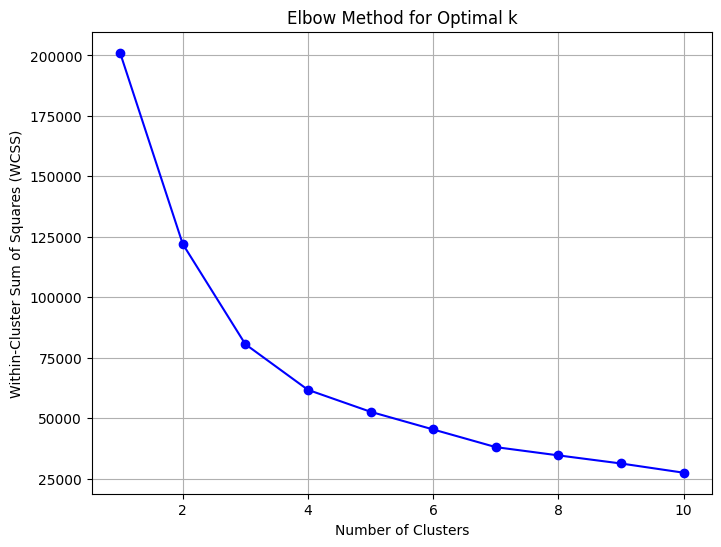

In [233]:
# Plot the WCSS values against the number of clusters
plt.figure(figsize=(8, 6))
plt.plot(k_range, wcss, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.grid(True)
plt.show()

### UMAP

In [234]:
!pip install umap-learn

In [235]:
import umap

In [236]:
umap_model = umap.UMAP()
embedding = umap_model.fit_transform(X)

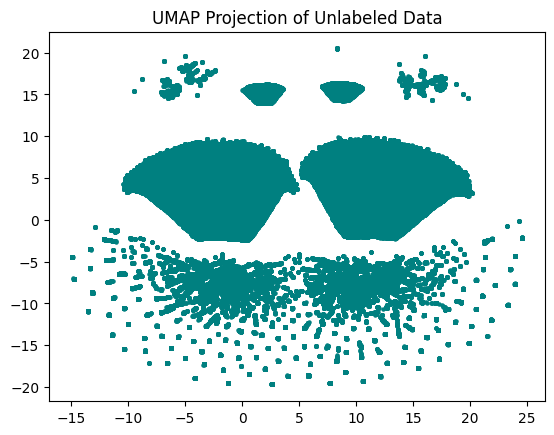

In [237]:
plt.scatter(embedding[:, 0], embedding[:, 1], s=5)
plt.title('UMAP Projection of Unlabeled Data')
plt.show()

In [238]:
embedding

array([[  6.95141  ,  -9.288982 ],
       [-14.760421 ,  -7.0516024],
       [  2.1438365,  -7.491706 ],
       ...,
       [ -3.3069532,   8.817586 ],
       [  1.4964283,   8.467712 ],
       [  1.1453651,   4.906998 ]], dtype=float32)

In [239]:
from sklearn.cluster import DBSCAN

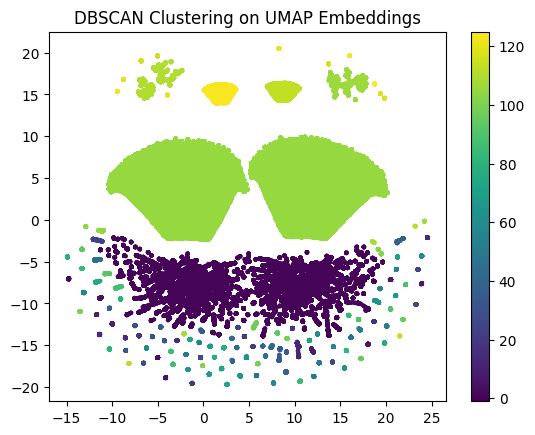

In [240]:
dbscan = DBSCAN(eps=0.9, min_samples=7)
dbscan_cluster_labels = dbscan.fit_predict(embedding)

# Plot the data points and color them by cluster labels
plt.scatter(embedding[:, 0], embedding[:, 1], c=dbscan_cluster_labels, s=5, cmap='viridis')

# Add colorbar to the plot to show the mapping of labels to colors
plt.colorbar()
plt.title('DBSCAN Clustering on UMAP Embeddings')
plt.show()

In [241]:
dbscan_cluster_labels.max()

125

In [242]:
kmeans = KMeans(n_clusters=8, init='k-means++', max_iter=10000, n_init=10, random_state=0)
k_means_cluster_labels = kmeans.fit_predict(embedding)

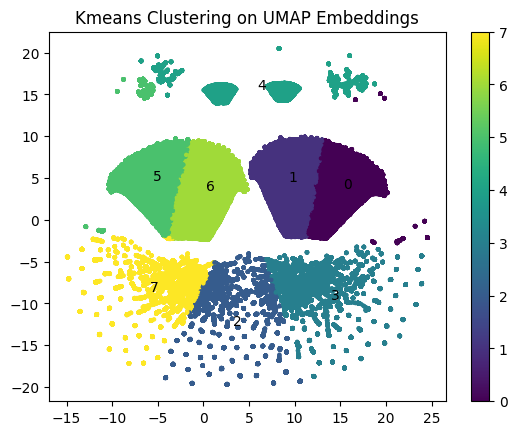

In [243]:
# Plot the data points and color them by cluster labels
plt.scatter(embedding[:, 0], embedding[:, 1], c=k_means_cluster_labels, s=5, cmap='viridis')

labels = list(set(k_means_cluster_labels))
for i, label in enumerate(labels):
    plt.text(kmeans.cluster_centers_[i, 0], kmeans.cluster_centers_[i, 1], label)
# Add colorbar to the plot to show the mapping of labels to colors
plt.colorbar()
plt.title('Kmeans Clustering on UMAP Embeddings')
plt.show()

In [248]:
X["LABEL_CLUSTER"] = k_means_cluster_labels

In [249]:
class_counts = X['LABEL_CLUSTER'].value_counts()
class_counts

6    61618
1    61272
0    53874
5    52546
3    26813
7    22650
2    21319
4    16224
Name: LABEL_CLUSTER, dtype: int64

In [250]:
X[(X['LABEL_CLUSTER'] == 5)] = 6
X[(X['LABEL_CLUSTER'] == 1)] = 0

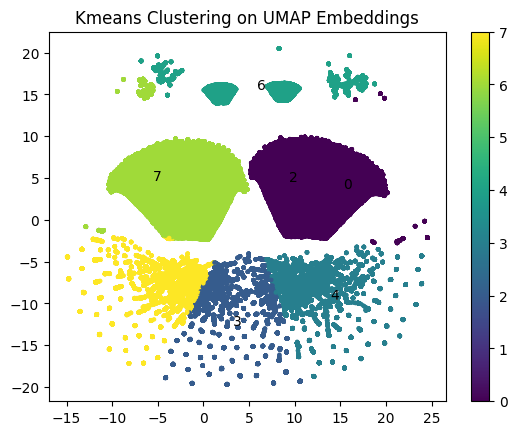

In [251]:
# Plot the data points and color them by cluster labels
plt.scatter(embedding[:, 0], embedding[:, 1], c=X['LABEL_CLUSTER'], s=5, cmap='viridis')

labels = list(set(X['LABEL_CLUSTER']))
for i, label in enumerate(labels):
    plt.text(kmeans.cluster_centers_[i, 0], kmeans.cluster_centers_[i, 1], label)
# Add colorbar to the plot to show the mapping of labels to colors
plt.colorbar()
plt.title('Kmeans Clustering on UMAP Embeddings')
plt.show()

In [252]:
from sklearn.model_selection import train_test_split
y = X["LABEL_CLUSTER"]
X = X.drop("LABEL_CLUSTER", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

## Cluster Prediction

{'boosting_type': 'gbdt', 'class_weight': 'balanced', 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 1.1246826503806984, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': 2, 'num_leaves': 31, 'objective': None, 'random_state': 7, 'reg_alpha': 0, 'reg_lambda': 0.7625758701327356, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}

In [253]:
import lightgbm as lgb

In [254]:
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)

LGBMClassifier()

In [255]:
y_pred=clf.predict(X_test)

In [256]:
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

LightGBM Model accuracy score: 0.9999


In [257]:
#!pip install shap

In [258]:
import shap
shap.initjs()

In [259]:
explainer = shap.TreeExplainer(clf)
X_sample = X_train.sample(10000)
shap_values = explainer.shap_values(X_sample)

In [260]:
shap.force_plot(explainer.expected_value[1], shap_values[2][0, :], X.iloc[0, :])

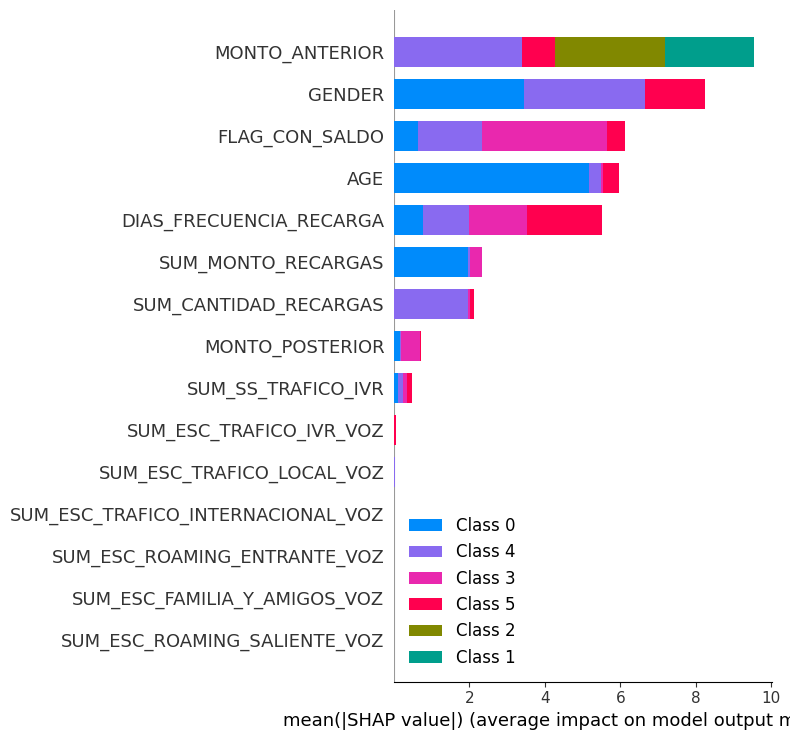

In [261]:
shap.summary_plot(shap_values, X_sample, plot_type="bar")

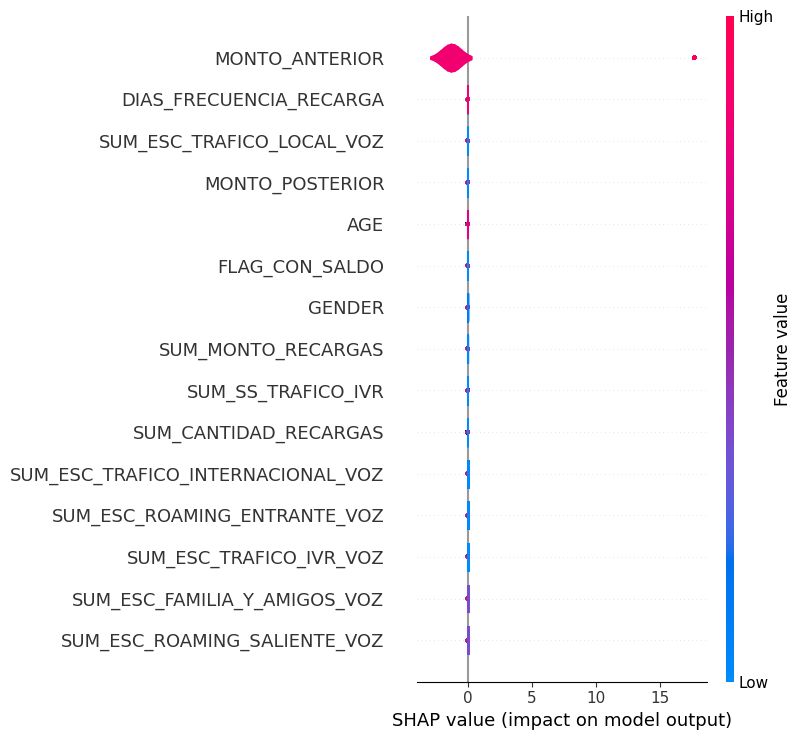

In [262]:
shap.summary_plot(shap_values[1], X_sample, plot_type="violin")

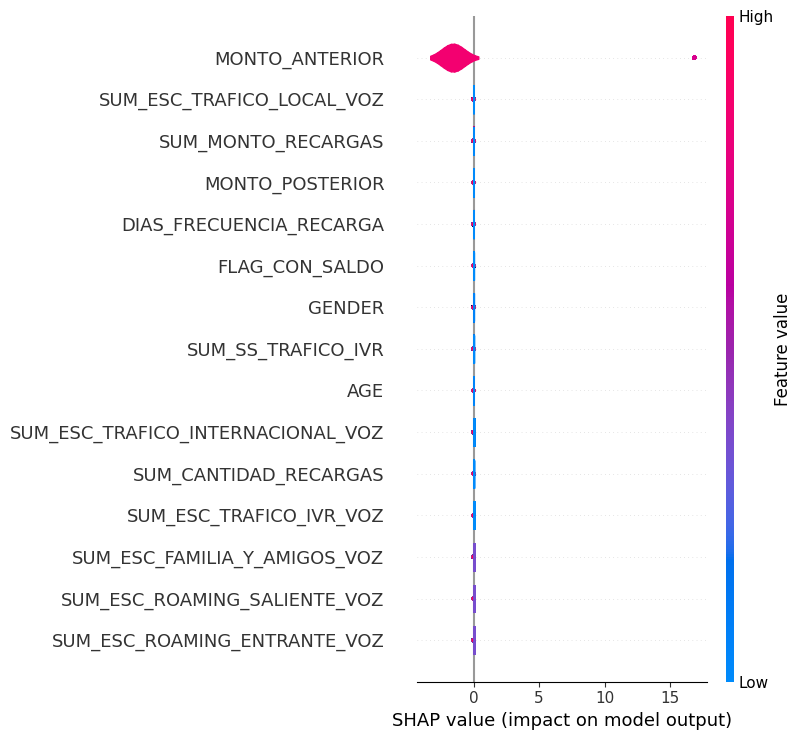

In [264]:
shap.summary_plot(shap_values[2], X_sample, plot_type="violin")

## Feature Importance

!pip install langchain## LangChain LLaMA

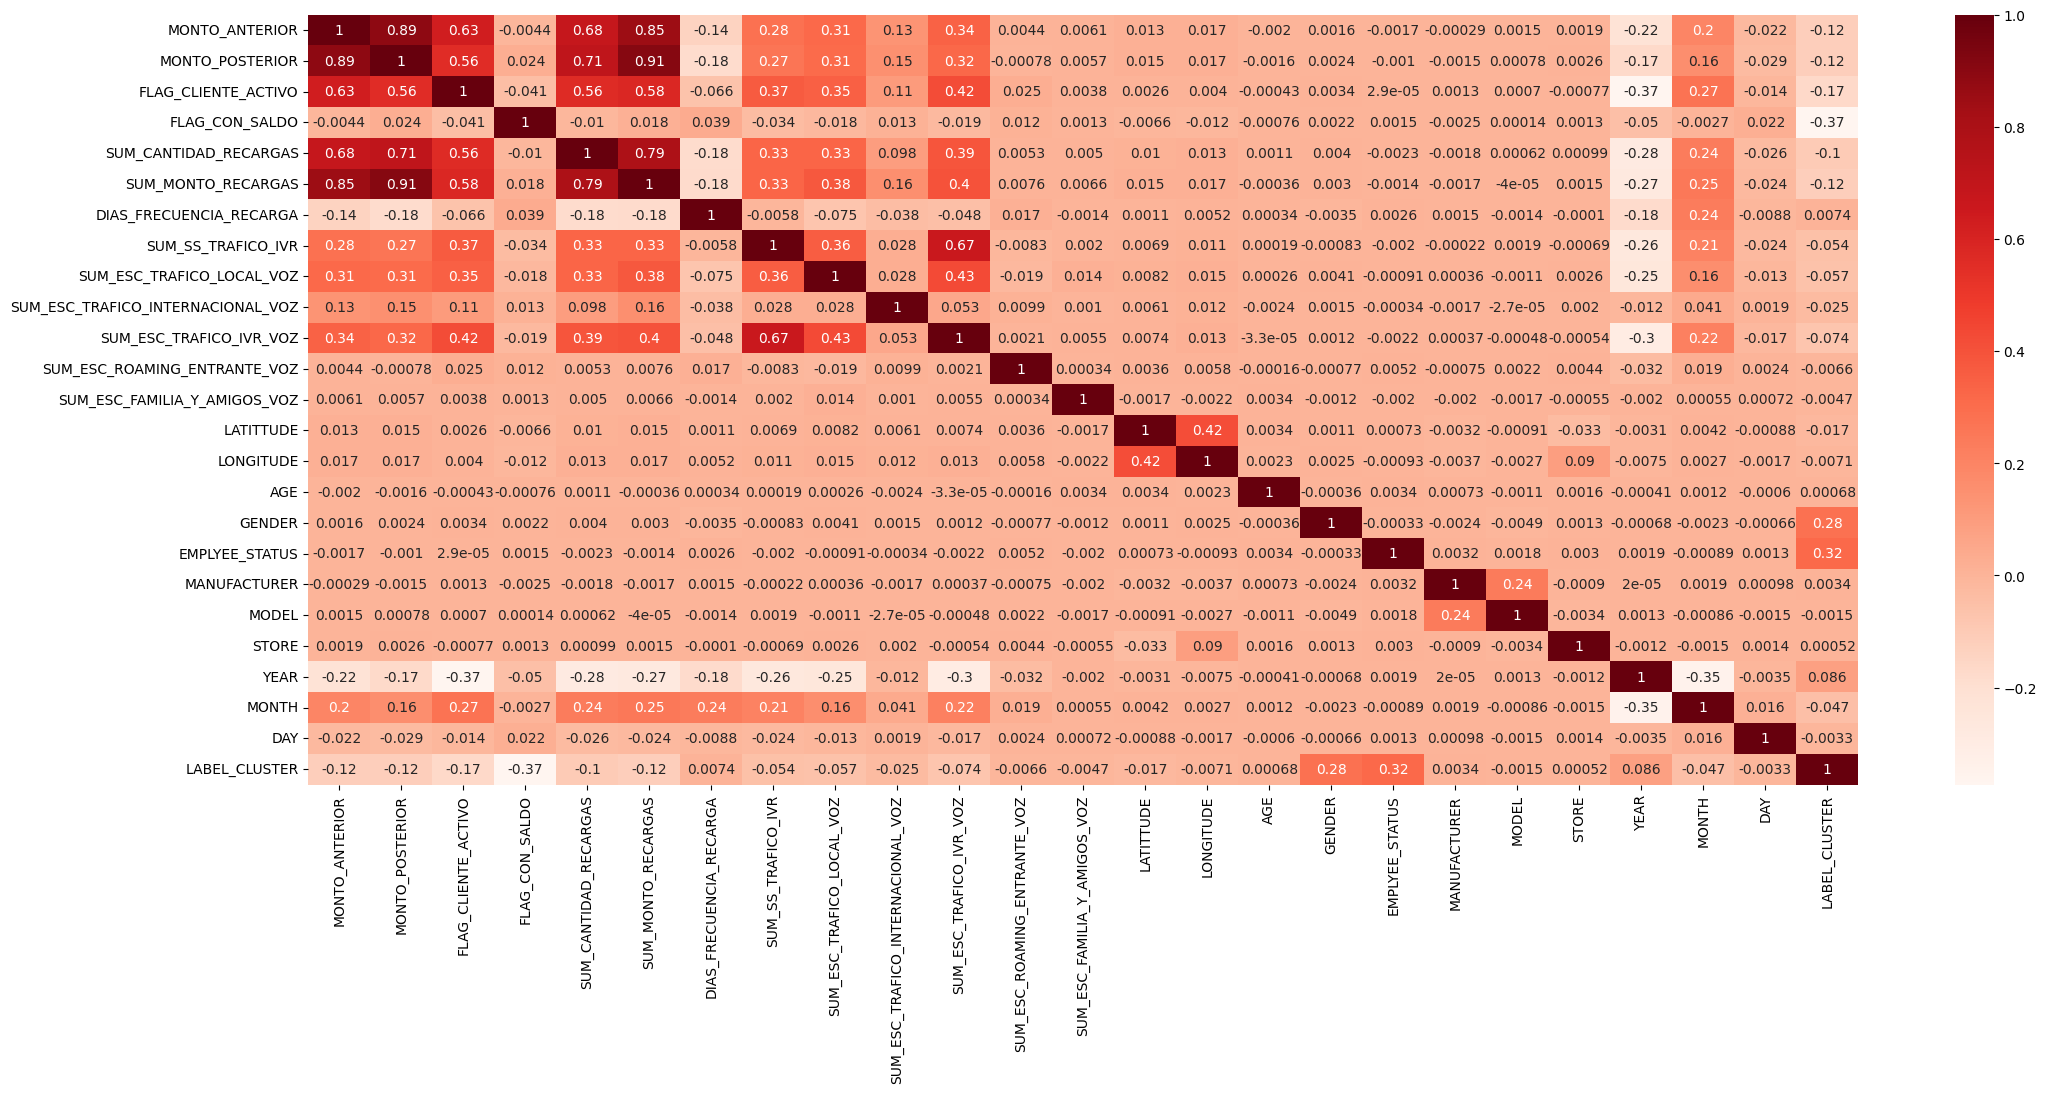

In [160]:
plt.figure(figsize=(25,10))
cor = X.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [170]:
cor_target = abs(cor["FLAG_CLIENTE_ACTIVO"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

MONTO_ANTERIOR           0.632639
MONTO_POSTERIOR          0.558284
FLAG_CLIENTE_ACTIVO      1.000000
SUM_CANTIDAD_RECARGAS    0.562164
SUM_MONTO_RECARGAS       0.584015
Name: FLAG_CLIENTE_ACTIVO, dtype: float64

In [180]:
import numpy as np

In [182]:
relevant_features = np.array(relevant_features.index)
XX = X.drop(relevant_features,1)   #Feature Matrix
y = X["FLAG_CLIENTE_ACTIVO"]          #Target Variable

## Random Forest feature importance

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(XX, y, test_size=0.20, random_state=46)

rf_model = RandomForestRegressor(random_state=42).fit(X_train, y_train)
y_pred = rf_model.predict(X_train)
np.sqrt(mean_squared_error(y_train, y_pred))

## LassoCV feature importance

In [184]:
from sklearn.linear_model import LassoCV

reg = LassoCV()
reg.fit(XX, y)

LassoCV()

In [186]:
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(XX,y))
coef = pd.Series(reg.coef_, index = XX.columns)

Best alpha using built-in LassoCV: 0.016156
Best score using built-in LassoCV: 0.198524


In [187]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  
      str(sum(coef == 0)) + " variables")

Lasso picked 4 variables and eliminated the other 16 variables


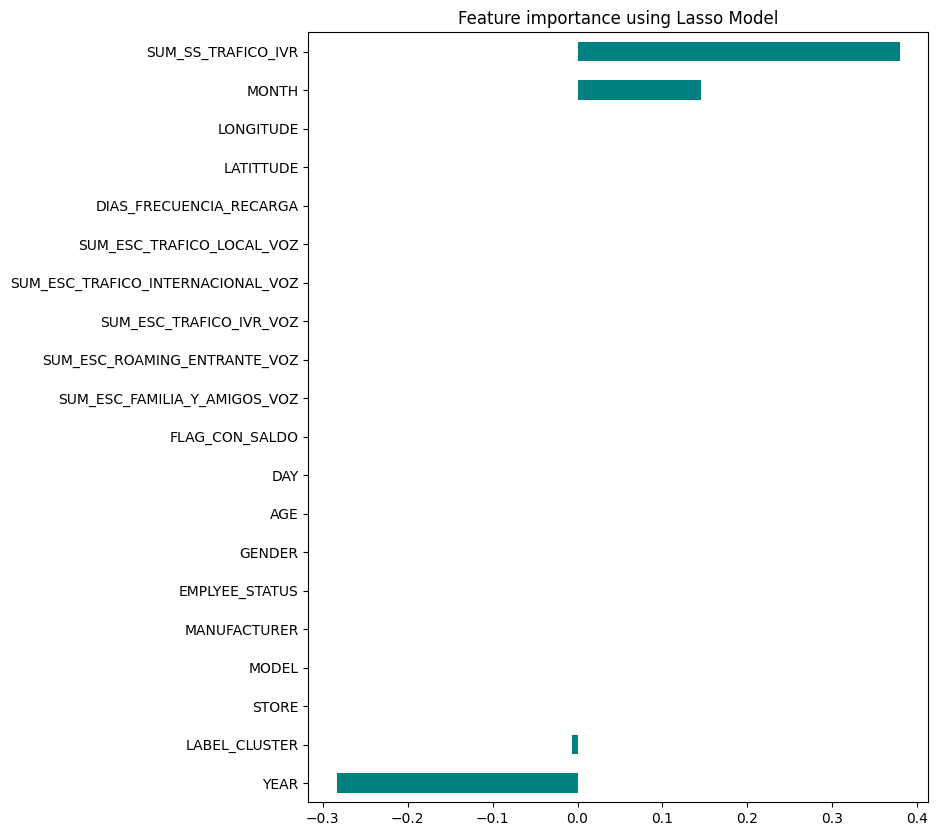

In [188]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")
plt.show()

## LLaMA

In [49]:
#!pip install langchain
#!pip install langchain[all]
#!pip install langchain-experimental
#!pip install requests google-auth
#!pip install google-cloud-aiplatform
#!pip install langchain google-cloud-aiplatform
!pip install vertexai --upgrade

In [68]:
import requests
import google.auth
import google.auth.transport.requests
from google.oauth2 import service_account

In [69]:
# Define the required SCOPES
SCOPES = ['https://www.googleapis.com/auth/cloud-platform']

# Replace 'NAME_OF_FILE' with your service account JSON file name that you downloaded
SERVICE_ACCOUNT_FILE = './active-module-403623-75e3ac30b498.json'

# Load credentials from the service account file with the specified SCOPES
cred = service_account.Credentials.from_service_account_file(
    SERVICE_ACCOUNT_FILE, scopes=SCOPES)

# Create an authentication request
auth_req = google.auth.transport.requests.Request()

# Refresh the credentials
cred.refresh(auth_req)

# Obtain the bearer token
bearer_token = cred.token

# Define the base URL for your specific region (us-central1 in this example)
base_url = "https://us-east1-aiplatform.googleapis.com/v1beta1/projects/{project_id}/locations/us-east1/endpoints/{endpoint_id}:predict"

# Replace 'awesome-dogfish-399811' with your GCP project ID
project_id = "active-module-403623"

# Replace '639689267970310144' with the Endpoint ID from the model dashboard
endpoint_id = "4755968332270665728"

In [70]:
# Define the request body for your specific prompt and parameters
request_body = {
    "instances": [
        {
            "prompt": "Write a poem about Valencia.",

            "top_k": 10
        }
    ]
}

# Create the full URL using the project and endpoint IDs
full_url = base_url.format(project_id=project_id, endpoint_id=endpoint_id)

headers = {
    "Authorization": "Bearer {bearer_token}".format(bearer_token=bearer_token),
    "Content-Type": "application/json"
}

# Send a POST request to the model endpoint
resp = requests.post(full_url, json=request_body, headers=headers)

# Print the response from the model
print(resp.json())

{'predictions': ['Prompt:\nWrite a poem about Valencia.\nOutput:\n Valencia, city of love\nSurrounded by the sea'], 'deployedModelId': '5128394910830952448', 'model': 'projects/223212713933/locations/us-east1/models/lallama', 'modelDisplayName': 'lallama', 'modelVersionId': '1'}


In [71]:
import google.auth
from google.oauth2.service_account import Credentials
credentials = Credentials.from_service_account_file(
    './active-module-403623-75e3ac30b498.json',
    scopes=['https://www.googleapis.com/auth/cloud-platform']
)

In [72]:
from langchain.llms import VertexAI
import vertexai

PROJECT_ID = "active-module-403623"
vertexai.init(project=PROJECT_ID, location="us-east1", credentials=credentials)

In [73]:
#!conda install protobuf=3.8.0
#!pip install google-api-core
#!pip install protobuf==3.20.2
#!pip install --upgrade google-cloud-aiplatform

In [74]:
llm = VertexAI(max_output_tokens=1000, temperature=0.3)

In [75]:
print(llm("tell me about Mexico City Dia de Muertos traditions"))

 **Mexico City Dia de Muertos Traditions**

Dia de Muertos, or Day of the Dead, is a Mexican holiday that celebrates the lives of deceased loved ones. The holiday is typically celebrated on November 1st and 2nd, and it is a time for families to come together and remember their loved ones who have passed away.

In Mexico City, Dia de Muertos is a major holiday, and the city comes alive with celebrations. The streets are filled with people dressed in colorful costumes, and there are parades, parties, and other events taking place all over the city.

One of the most important traditions of Dia de Muertos is the creation of altars, or ofrendas. These altars are typically set up in homes, but they can also be found in public spaces. Ofrendas are decorated with flowers, candles, food, and other items that the deceased loved one enjoyed. The altars are a way to honor the deceased and to show them that they are still loved and remembered.

Another important tradition of Dia de Muertos is the m

In [76]:
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent
from sklearn.datasets import load_diabetes

In [77]:
data = load_diabetes()
df = pd.DataFrame(data.data, columns=data.feature_names)

In [78]:
agent = create_pandas_dataframe_agent(llm, X, verbose=True)

In [79]:
df

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641
...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018114,0.044485
439,0.041708,0.050680,-0.015906,0.017293,-0.037344,-0.013840,-0.024993,-0.011080,-0.046883,0.015491
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044529,-0.025930


In [104]:
agent.run("What can you interpret from the LABEL_CLUSTER column and the main differences between clusters?")



> Entering new AgentExecutor chain...
 Thought: The values in the LABEL_CLUSTER column seem to be categorical, and they may represent different customer segments. I can look at the unique values in this column to get a better understanding of the different clusters.
Action: python_repl_ast
Action Input: df['LABEL_CLUSTER'].unique()
Observation: [ 5  0  3 12  4  7  9 14  1  8  6 13  2 11 10 15]
Thought: There are 16 unique values in the LABEL_CLUSTER column, which suggests that there are 16 different customer segments. 
Final Answer: The LABEL_CLUSTER column contains 16 unique values, suggesting that there are 16 different customer segments.


> Finished chain.


'The LABEL_CLUSTER column contains 16 unique values, suggesting that there are 16 different customer segments.'

In [105]:
agent.run("select the features that best differentiate the cluster in LABEL_CLUSTER")



> Entering new AgentExecutor chain...
 Thought: To find the features that best differentiate the clusters in LABEL_CLUSTER, we can use the `SelectKBest` class from `sklearn.feature_selection`. This class can be used to select the k best features based on their scores. We can use the `chi2` scoring function to measure the independence between the features and the target variable.
Action: python_repl_ast
Action Input: 
```python
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# Create a SelectKBest object with the chi2 scoring function
selector = SelectKBest(chi2, k=5)

# Fit the selector to the data
selector.fit(df.drop('LABEL_CLUSTER', axis=1), df['LABEL_CLUSTER'])

# Get the indices of the selected features
selected_features = selector.get_support(indices=True)

# Print the selected features
print(df.drop('LABEL_CLUSTER', axis=1).columns[selected_features])
```

Observation: Index(['FLAG_CON_SALDO', 'LATITTUDE', 'LONGITUDE', 'GENDER', 'E

'FLAG_CON_SALDO, LATITTUDE, LONGITUDE, GENDER, EMPLYEE_STATUS'

In [106]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# Create a SelectKBest object with the chi2 scoring function
selector = SelectKBest(chi2, k=5)

# Fit the selector to the data
selector.fit(X.drop('LABEL_CLUSTER', axis=1), X['LABEL_CLUSTER'])

# Get the indices of the selected features
selected_features = selector.get_support(indices=True)

# Print the selected features
print(X.drop('LABEL_CLUSTER', axis=1).columns[selected_features])

Index(['FLAG_CON_SALDO', 'LATITTUDE', 'LONGITUDE', 'GENDER', 'EMPLYEE_STATUS'], dtype='object')


In [94]:
(X.groupby('LABEL_CLUSTER')['LABEL_CLUSTER'].count() - X.groupby('LABEL_CLUSTER')['LABEL_CLUSTER'].count().mean()) / (X.groupby('LABEL_CLUSTER')['LABEL_CLUSTER'].count() + X.groupby('LABEL_CLUSTER')['LABEL_CLUSTER'].count().mean())

LABEL_CLUSTER
0     0.190158
1     0.184664
2     0.185957
3     0.184126
4     0.184311
5     0.011556
6     0.188080
7     0.008383
8     0.008308
9     0.002378
10   -0.420100
11   -0.724977
12    0.012173
13    0.011753
14   -0.720698
15   -0.414816
Name: LABEL_CLUSTER, dtype: float64

In [95]:
new_df = pd.DataFrame()

In [96]:
new_df["X.groupby('LABEL_CLUSTER')['LABEL_CLUSTER'].count()"] = X.groupby('LABEL_CLUSTER')['LABEL_CLUSTER'].count()
new_df["X.groupby('LABEL_CLUSTER')['LABEL_CLUSTER'].count().mean())"] = X.groupby('LABEL_CLUSTER')['LABEL_CLUSTER'].count().mean()
new_df["X.groupby('LABEL_CLUSTER')['LABEL_CLUSTER'].count()"] = X.groupby('LABEL_CLUSTER')['LABEL_CLUSTER'].count()
new_df["X.groupby('LABEL_CLUSTER')['LABEL_CLUSTER'].count().mean()"] = X.groupby('LABEL_CLUSTER')['LABEL_CLUSTER'].count().mean()

In [97]:
new_df

,X.groupby('LABEL_CLUSTER')['LABEL_CLUSTER'].count(),X.groupby('LABEL_CLUSTER')['LABEL_CLUSTER'].count().mean()),X.groupby('LABEL_CLUSTER')['LABEL_CLUSTER'].count().mean()
LABEL_CLUSTER,,,
0,29054,19769.75,19769.75
1,28725,19769.75,19769.75
2,28802,19769.75,19769.75
3,28693,19769.75,19769.75
4,28704,19769.75,19769.75
5,20232,19769.75,19769.75
6,28929,19769.75,19769.75
7,20104,19769.75,19769.75
8,20101,19769.75,19769.75


In [99]:
agent_2 = create_pandas_dataframe_agent(llm, new_df, verbose=True)

In [103]:
#agent_2.run("Based on this formula, what can you tell are the main differences between clusters?: (cluster1_count - cluster2_count) / (cluster1_count + cluster2_count)")

In [107]:
# https://www.kaggle.com/code/emilytries/clustering-and-feature-selection

# Check this one out